# **Deep Learning**

### **Nama:** Verren Angelina Saputra
### **NIM:** 2602093600

- Model: https://huggingface.co/microsoft/MiniLM-L12-H384-uncased
- Dataset: https://www.kaggle.com/datasets/raflyahmadzainur/spam-dataset-indonesia/code

# **1. Import Library**

Training model dilakukan dengan platform kaggle dengan GPU 100

In [ ]:
import numpy as np
import pandas as pd

# Memasukkan input berupa direktori dataset yang diperlukan
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spam.csv


In [ ]:
# Perintah yang digunakan untuk menginstal pustaka pada lingkungan Python
# melakukan instalasi transformer, accelerate, dan datasets supaya bisa import variasi library dari pustaka ini

!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 8.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [ ]:
# import packages dan libraries yang diperlukan : mulai dari basic library sampai pustaka transformer, accelerate, dan sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import transformers, torch, datasets, os, json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging

import accelerate
from accelerate import notebook_launcher
from accelerate import Accelerator

# import library warnings untuk filterisasi warnings yang tidak diperlukan / abaikan warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Memeriksa apakah GPU tersedia di mesin yang sedang digunakan, khususnya menggunakan CUDA untuk komputasi dengan kompleksitas yang tinggi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **2. Membaca Dataset**

Menggunakan dataset yang bersumber dari kaggle. Dataset ini berisi sebuah informasi teks yang dianggap sebagai spam dan tidak spam. Maka dari itu, pre-trained model huggingface membantu analisa dengan teks classification

In [ ]:
# Gunakan direktori yang sesuai
df = pd.read_csv('/kaggle/input/spam.csv') #Change the path

In [ ]:
# Print informasi mengenai dataset, terdapat 2 jenis kolom saja yaitu kategori dan pesan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  2636 non-null   object
 1   Pesan     2636 non-null   object
dtypes: object(2)
memory usage: 41.3+ KB


In [ ]:
# Terdapat 2636 baris dengan 2 kolom secara keseluruhan
df.shape

(2636, 2)

# **3. Pre-processing Dataset**

Membersihkan data dan melakukan balancing data. Kualitas initial data yang kita pakai akan mempengaruhi performance model dalam mempelajari setiap data yang diberikan

In [ ]:
# Melakukan pengecekkan apakah terdapat data null atau tidak
df.isnull().sum()

Kategori    0
Pesan       0
dtype: int64

In [ ]:
# Melakukan pengecekkan apakah terdapat data duplikat atau tidak
df.duplicated().sum()

16

In [ ]:
# Drop setiap data duplikat
df = df.drop_duplicates()

In [ ]:
# Cek ulang total data duplikat
df.duplicated().sum()

0

In [ ]:
# Cek ulang jumlah baris yang tersisa
df.shape

(2620, 2)

In [ ]:
# Lihat jumlah masing-masing kategori : spam dan ham (not spam)
df.Kategori.value_counts()

Kategori
spam    1368
ham     1252
Name: count, dtype: int64

In [ ]:
# Encode label jadi 0 (ham) dan 1 (spam)
df['label'] = df.Kategori.apply(lambda x: 1 if x == 'spam' else 0)
df.label.value_counts()

label
1    1368
0    1252
Name: count, dtype: int64

In [ ]:
# Tampilkan 5 data teratas yang sudah di encode
df.head()

,Kategori,Pesan,label
0,spam,Secara alami tak tertahankan identitas perusah...,1
1,spam,Fanny Gunslinger Perdagangan Saham adalah Merr...,1
2,spam,Rumah -rumah baru yang luar biasa menjadi muda...,1
3,spam,4 Permintaan Khusus Pencetakan Warna Informasi...,1
4,spam,"Jangan punya uang, dapatkan CD perangkat lunak...",1


In [ ]:
# Menyeleksi dua kolom spesifik dari DataFrame utama
df_label=df[['label','Pesan']]
df_label.head()

,label,Pesan
0,1,Secara alami tak tertahankan identitas perusah...
1,1,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,1,Rumah -rumah baru yang luar biasa menjadi muda...
3,1,4 Permintaan Khusus Pencetakan Warna Informasi...
4,1,"Jangan punya uang, dapatkan CD perangkat lunak..."


In [ ]:
# Melakukan instalasi pustaka imbalanced-learn
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Melakukan balancing value dalam kategori ham dan spam dengan oversampling
# Random Oversampling menangani masalah class imbalance dalam dataset, terutama ketika jumlah sampel dari satu kelas jauh lebih sedikit dibandingkan kelas lainnya.

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
df_resampled, label_resampled = ros.fit_resample(df_label[['Pesan']], df_label['label'])

# Menyimpan hasil resampling ke dalam dataframe
df_resampled['label'] = label_resampled
print(df_resampled)

                                                  Pesan  label
0     Secara alami tak tertahankan identitas perusah...      1
1     Fanny Gunslinger Perdagangan Saham adalah Merr...      1
2     Rumah -rumah baru yang luar biasa menjadi muda...      1
3     4 Permintaan Khusus Pencetakan Warna Informasi...      1
4     Jangan punya uang, dapatkan CD perangkat lunak...      1
...                                                 ...    ...
2731  Sebuah makalah saya Vince, saya telah menulis ...      0
2732  Pengumuman Organisasi Kami dengan senang hati ...      0
2733  Posisi ahli statistik terbuka, jangan ragu unt...      0
2734  Tuan -tuan, berbicara kepada Vince K hari ini ...      0
2735  Buku Derivatif Energi Hi Vince, senang berbica...      0

[2736 rows x 2 columns]


In [ ]:
# Tampilkan data yang sudah di oversampling
print(df_resampled.label.value_counts())
print(df_resampled.shape)

label
1    1368
0    1368
Name: count, dtype: int64
(2736, 2)


# **4. Splitting Data**

Membagi data untuk training testing dan validation, dimana test_size = 0.3

In [ ]:
# Membagi dataset df_resampled menjadi dua bagian, yaitu 70% data pelatihan/validasi (train_val) dan 30% data pengujian (test)
# secara acak dengan memastikan hasil acak yang konsisten menggunakan random_state=42.
train_val, test = train_test_split(df_resampled, test_size=0.3, random_state=42,shuffle=True)

In [ ]:
# Membagi data train_val yang sebelumnya sudah dipisahkan, menjadi dua bagian: 70% untuk pelatihan (train) dan 30% untuk validasi (val)
train,val=train_test_split(train_val, test_size=0.3, random_state=42,shuffle=True)

In [ ]:
# print shape masing-masing data yang sudah di splitting
train.shape, val.shape, test.shape

((1340, 2), (575, 2), (821, 2))

# **5. Pre-trained Model**

Menggunakan pre-trained model dari protectai yaitu microsoft/MiniLM-L12-H384-uncased
- Arsitektur Model: MiniLM (Mini Language Model) adalah versi ringan dari model transformer seperti BERT, yang dirancang untuk memberikan kinerja tinggi dengan ukuran yang jauh lebih kecil.
- L12: Model ini memiliki 12 layer (lapisan) di dalam arsitektur transformernya.
- Setiap layer memiliki ukuran hidden state sebesar 384 dimensi, yang jauh lebih kecil dibandingkan model transformer besar lainnya seperti BERT atau RoBERTa.
- Ini adalah model uncased, yang berarti huruf besar dan kecil diperlakukan sama (case-insensitive). Jadi, misalnya, "apple" dan "Apple" akan diperlakukan sebagai kata yang sama.

In [ ]:
pretrained_model='microsoft/MiniLM-L12-H384-uncased'

In [ ]:
# Tokenizer ini sedang dimuat untuk model pre-trained
# dan proses tersebut memerlukan pengunduhan beberapa file penting yang mengatur bagaimana teks akan diproses menjadi token.
# Tokenizer adalah bagian penting dalam sistem pemrosesan bahasa alami (NLP) untuk mengonversi teks menjadi format numerik yang bisa dipahami oleh model AI.
tokenizer=AutoTokenizer.from_pretrained(pretrained_model)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Kode ini melakukan tokenisasi pada teks dalam kolom 'Pesan' dari df_resampled menggunakan tokenizer yang telah dimuat.
token_lengths = [len(tokenizer(text)['input_ids']) for text in df_resampled['Pesan']]

# token length = daftar yang menyimpan panjang token (jumlah token) untuk setiap pesan dalam dataset setelah tokenisasi.
max_length = max(token_lengths)
mean_length = sum(token_lengths) / len(token_lengths)
median_length = sorted(token_lengths)[len(token_lengths) // 2]

# Mengeksplorasi distribusi panjang token dalam dataset, memberikan informasi seperti panjang terpanjang, rata-rata, dan median
# yang penting dalam menentukan konfigurasi seperti max_length untuk model machine learning.
print(f"Max token length: {max_length}")
print(f"Mean token length: {mean_length}")
print(f"Median token length: {median_length}")

Max token length: 11968
Mean token length: 544.2766812865497
Median token length: 315


In [ ]:
# Maka max length yang paling pas adalah 512
max_length=512

In [ ]:
# tokenize_function mempersiapkan teks dengan melakukan tokenisasi, truncation, dan padding sesuai panjang maksimum yang diizinkan.
def tokenize_function(examples):
    return tokenizer(examples['Pesan'], truncation=True,padding='max_length',max_length=max_length)

# convert_to_dataset mengonversi DataFrame pandas menjadi format Dataset Hugging Face dan menerapkan tokenisasi ke seluruh dataset,
# serta membersihkan kolom teks asli setelah tokenisasi dilakukan.
def convert_to_dataset(dataframe):
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    dataset = dataset.map(tokenize_function, batched=True)
    dataset=dataset.remove_columns(['Pesan'])
    return dataset

In [ ]:
# Kode ini mempersiapkan dataset pelatihan dan validasi dalam format yang telah ditokenisasi
# dan siap diproses oleh model Transformer untuk proses pelatihan (training) dan validasi (evaluation).
tokenized_train = convert_to_dataset(train)
tokenized_val = convert_to_dataset(val)

Map:   0%|          | 0/1340 [00:00<?, ? examples/s]

Map:   0%|          | 0/575 [00:00<?, ? examples/s]

In [ ]:
# Data collator memastikan input dalam batch diproses dengan panjang yang sama, penting untuk efisiensi pelatihan.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model diload dari model pre-trained untuk tugas klasifikasi, dan disesuaikan untuk klasifikasi dua kelas.
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=2)

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# MultiGPU training
accelerator = Accelerator()

In [ ]:
# Digunakan untuk mengatur berbagai parameter yang terkait dengan pelatihan model
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy='epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=32, # Jumlah sampel per batch selama pelatihan adalah 32
    per_device_eval_batch_size=32, # Jumlah sampel per batch selama evaluasi adalah 32
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none",
    eval_steps=5,
    logging_steps=5,
)

# Membuat Trainer untuk menangani pelatihan model
trainer = Trainer(
    model=model, # Model yang dilatih adalah model klasifikasi sekuens yang telah diload sebelumnya
    args=training_args, # Menggunakan parameter pelatihan yang telah diatur di TrainingArguments
    train_dataset=tokenized_train, # Dataset pelatihan yang sudah ditokenisasi
    eval_dataset=tokenized_val, # Dataset validasi yang sudah ditokenisasi
    tokenizer=tokenizer, # Tokenizer yang digunakan untuk pelatihan
    data_collator=data_collator, # Data collator yang mengatur padding pada setiap batch
)

# Accelerator digunakan untuk mengelola pelatihan yang lebih efisien, seperti menjalankan pada GPU atau multi-device secara otomatis.
model, trainer = accelerator.prepare(model, trainer)

# Menjalankan proses pelatihan model berdasarkan semua pengaturan yang telah disediakan
trainer.train()

Step,Training Loss
5,0.694200
10,0.690200
15,0.688800
20,0.685400
25,0.666800
30,0.654000
35,0.570100
40,0.499200
45,0.459900
50,0.435000


TrainOutput(global_step=126, training_loss=0.43155549537567867, metrics={'train_runtime': 95.0887, 'train_samples_per_second': 42.276, 'train_steps_per_second': 1.325, 'total_flos': 264808375050240.0, 'train_loss': 0.43155549537567867, 'epoch': 3.0})

In [ ]:
# Menonaktifkan Weights and Biases (WandB)

os.environ['WANDB_DISABLED'] = 'true'

# **6. Evaluasi Model**

In [ ]:
# Dataset uji (test) diubah menjadi format Dataset dan ditokenisasi menggunakan fungsi convert_to_dataset
tokenized_test = convert_to_dataset(test)
tokenized_test = tokenized_test.remove_columns(['label'])

# Membuat objek Trainer yang digunakan untuk membuat prediksi
trainer = Trainer(model=model, tokenizer=tokenizer, data_collator=data_collator)
# Menggunakan Trainer untuk memprediksi label dari dataset uji yang telah ditokenisasi
predictions = trainer.predict(tokenized_test)

# Mengambil hasil prediksi dan menggunakan argmax untuk mendapatkan label prediksi
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Menghitung metrik evaluasi utama (precision, recall, dan F1 score) untuk menilai performa model terhadap dataset uji
precision, recall, fscore, _ = score(test['label'], predicted_labels, average='binary')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {fscore:.4f}')

Map:   0%|          | 0/821 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Precision: 0.9622
Recall: 0.8537
F1 Score: 0.9047


In [ ]:
# print hasil klasifikasi report, dengan akurasi mencapai 91%
print(classification_report(test['label'], predicted_labels, target_names=['not spam', 'spam']))

              precision    recall  f1-score   support

    not spam       0.86      0.97      0.91       404
        spam       0.96      0.85      0.90       417

    accuracy                           0.91       821
   macro avg       0.91      0.91      0.91       821
weighted avg       0.91      0.91      0.91       821



### **Hasil Classification Report**

- Model memiliki performa keseluruhan yang baik dengan akurasi 91%. Model memprediksi dengan benar 91% dari total 821 contoh data.
- Recall untuk spam (0.85) lebih rendah dibandingkan recall untuk not spam (0.97), menunjukkan model agak kesulitan mendeteksi semua spam.
- Precision untuk spam (0.96) sangat tinggi, yang berarti ketika model memprediksi spam, hasilnya sangat akurat.

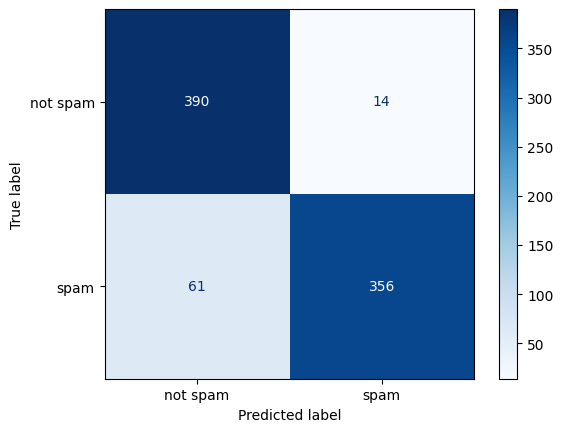

In [ ]:
# Menampilkan hasil confusion matrix
cm = confusion_matrix(test['label'], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not spam', 'spam'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### **Hasil Confusion Matrix**

- Model bekerja baik dalam mendeteksi not spam, dengan 390 prediksi benar dan hanya 14 prediksi salah.
- Ada 61 kasus spam yang tidak terdeteksi, di mana model salah memprediksi sebagai not spam.
- Prediksi spam juga cukup baik dengan 356 kasus yang dideteksi benar dari total kasus spam.

Model bekerja baik secara umum, tetapi ada beberapa kesalahan dalam mendeteksi spam (false negatives) yang bisa lebih diperbaiki.

In [ ]:
# Membuat fungsi untuk melakukan prediksi output
def predict_spam_ham(text):
    inputs = tokenizer(text, return_tensors="pt")
    inputs=inputs.to(device)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return "spam" if torch.argmax(probs) == 1 else "not spam"

In [ ]:
# Hasil prediksi output
input_text_1 ='Selamat! Anda telah terpilih untuk mendapatkan iPhone terbaru GRATIS. Klik link berikut untuk mengklaim hadiah Anda sekarang!'
input_text_2 = 'Ingat meeting kita besok jam 10 pagi. Jangan lupa bawa catatan pertemuan sebelumnya.'
print(f'Output dari input text-1 : {predict_spam_ham(input_text_1)}')
print(f'Output dari input text-2 : {predict_spam_ham(input_text_2)}')

Output dari input text-1 : spam
Output dari input text-2 : not spam


### **Hasil Prediksi**

Berdasarkan hasil prediksi, dapat kita simpulkan bahwa model sudah melakukan klasifikasi dengan optimal. Seluruh input sudah menghasilkan output yang sesuai:
- Input teks 1 merupakan spam karena mengirimkan pesan dengan kata-kata promosi berlebihan dan mencurigakan, maka terdeteksi benar sebagai SPAM
- Input teks 2 merupakan kalimat normal yang hanya menginformasikan jadwal meeting, maka terdeteksi benar sebagai NOT SPAM